In [1]:
import glob
import sys
import os
import cv2
import numpy as np
print(cv2.__version__)
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import time
from keras.models import Sequential
from keras.layers import InputLayer, Input , Conv2D, Dense, Flatten , Reshape , MaxPooling2D , Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate

3.4.1


C:\Users\NafiS\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from data_utils import load_tl_extracts
from random_mini_batch import random_mini_batches

In [3]:
desired_dim = (64,64)
data_dirs = ['data']
test_data = ['test']

In [4]:
x_train, y_train = load_tl_extracts(data_dirs, desired_dim)
x_test,y_test = load_tl_extracts(test_data, desired_dim)
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.shape)
print('x test shape: ',x_test.shape)
print('y test shape: ',y_test.shape)

x train shape:  (12503, 64, 64, 3)
y train shape:  (12503,)
x test shape:  (13486, 64, 64, 3)
y test shape:  (13486,)


In [5]:
#keep only green,red,yellow,off,background
relevant = ['green','off','yellow','red','background']
x_train = x_train[np.isin(y_train, relevant)]
y_train = y_train[np.isin(y_train, relevant)]

In [6]:
print('After keeping Only 5 Classes: ')
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.reshape((11189,1)).shape)
print('x test shape: ',x_test.shape)
print('y test shape: ',y_test.reshape((13486,1)).shape)

After keeping Only 5 Classes: 
x train shape:  (11189, 64, 64, 3)
y train shape:  (11189, 1)
x test shape:  (13486, 64, 64, 3)
y test shape:  (13486, 1)


In [7]:
x_train = x_train.reshape(-1, 64, 64, 3)
x_test = x_test.reshape(-1, 64, 64, 3)
print('x train shape: ',x_train.shape)
print('x test shape: ',x_test.shape)

x train shape:  (11189, 64, 64, 3)
x test shape:  (13486, 64, 64, 3)


In [8]:
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.

In [9]:
from numpy import array
values_train = array(y_train)
values_test = array(y_test)
print(values_train)
print(values_test)

['yellow' 'yellow' 'yellow' ... 'background' 'background' 'background']
['green' 'green' 'green' ... 'green' 'green' 'green']


In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(values_train)
print(y_train[0:10])

[4 4 4 3 3 3 3 3 3 3]


In [11]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
print(y_train[0])

[0. 0. 0. 0. 1.]


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.33, random_state=42)

In [13]:
print('x train shape: ',x_train.shape)
print('y train shape: ',y_train.shape)
print('x validation shape: ',x_validation.shape)
print('y validation shape: ',y_validation.shape)

x train shape:  (7496, 64, 64, 3)
y train shape:  (7496, 5)
x validation shape:  (3693, 64, 64, 3)
y validation shape:  (3693, 5)


In [14]:
model = Sequential()
model.add(Conv2D(kernel_size=7, strides=1, filters=32, padding='same',
                 activation='relu',input_shape = (64, 64, 3), name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(kernel_size=3, strides=1, filters=64, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(kernel_size=3, strides=1, filters=128, padding='same',
                 activation='relu', name='layer_conv3'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 64, 64, 32)        4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 16, 16, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
__________

In [16]:
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [17]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [18]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [29]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=50, #Increase this when not on Kaggle kernel
                           validation_data=(x_validation, y_validation), #For speed
                           callbacks=[annealer])

Epoch 1/15
500/500 [==============================] - 189s 378ms/step - loss: 0.2254 - acc: 0.9299 - val_loss: 0.1707 - val_acc: 0.9534
Epoch 2/15
246/500 [=============>................] - ETA: 1:29 - loss: 0.1900 - acc: 0.9388

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\NafiS\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-951a01f9b583>", line 5, in <module>
    callbacks=[annealer])
  File "C:\Users\NafiS\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\NafiS\Anaconda3\lib\site-packages\keras\models.py", line 1276, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\NafiS\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\NafiS\Anaconda3\lib\site-packages\keras\engine\training.py", line 2224, in fit_generator
    class_weight=class_weight)
  File "C:\Users\NafiS\Anaconda3\lib\site-packages\keras\engine\training.py", line 1883, in train_on_batch
    outputs = self.train_function(ins)
  File "C:\Users\NafiS\Anaconda3\li

KeyboardInterrupt: 

In [20]:
final_loss, final_acc = model.evaluate(x_validation, y_validation, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.1406, final accuracy: 0.9564


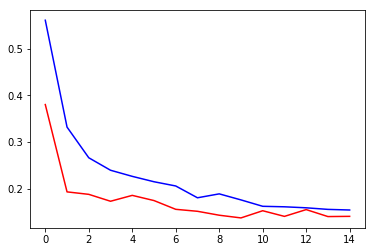

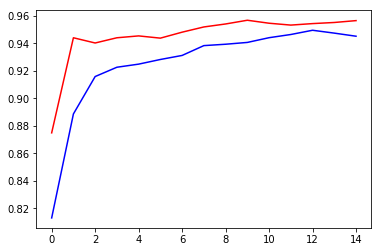

In [21]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [22]:
y_train_pred = model.predict(x=x_train)
y_train_pred = np.argmax(y_train_pred,axis=1)
y_val_pred = model.predict(x=x_validation)
y_val_pred = np.argmax(y_val_pred,axis=1)

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
target_names = ['class 0', 'class 1', 'class 2', 'class 3','class 4']
y_tain_true_class = np.argmax(y_train,axis=1)
y_validation_true_class = np.argmax(y_validation,axis=1)
print("train accuricy: %f" % accuracy_score(y_tain_true_class, y_train_pred))
print("validation accuricy: %f" % accuracy_score(y_validation_true_class, y_val_pred))

train accuricy: 0.959178
validation accuricy: 0.956404


In [25]:
print(classification_report(y_validation_true_class, y_val_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.98      1.00      0.99       598
    class 1       0.98      0.99      0.99      1705
    class 2       0.95      0.75      0.84       240
    class 3       0.93      0.97      0.95      1011
    class 4       0.78      0.58      0.66       139

avg / total       0.95      0.96      0.95      3693



In [26]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

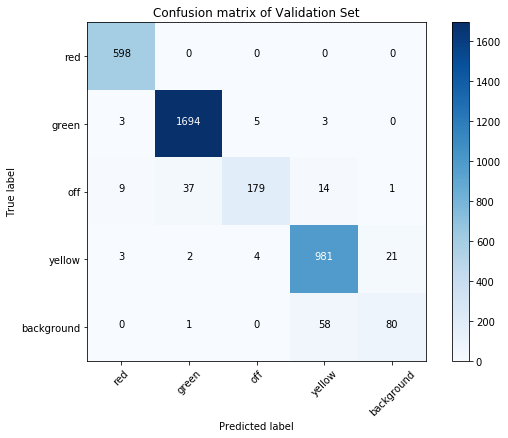

In [27]:
cnf_matrix = confusion_matrix(y_validation_true_class,y_val_pred)
class_names =  ['red','green','off','yellow','background']
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix of Validation Set')